# Lion Cheetah Classification task

Baed on the following Kaggle data set: https://www.kaggle.com/datasets/mikoajfish99/lions-or-cheetahs-image-classification

In [126]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
import cv2
import os
import imghdr

In [127]:
# Avoid OOM errors by setting GPU Memory Consumption Growth
gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus: 
    tf.config.experimental.set_memory_growth(gpu, True)

In [128]:
# Removing dodgy images

image_exts = ['jpeg', 'jpg', 'bmp', 'png']

data_dir = 'images'
for image_class in os.listdir(data_dir):
    # Ignore .DS_Store file
    if image_class == ".DS_Store":
        continue
    
    class_dir = os.path.join(data_dir, image_class)
    
    for image in os.listdir(class_dir):
        # Ignore .DS_Store file
        if image == ".DS_Store":
            continue
        
        image_path = os.path.join(class_dir, image)
        # Process image_path as needed

        try:
            img = cv2.imread(image_path)
            tip = imghdr.what(image_path)
            if tip not in image_exts:
                print('Image not in ext list {}'.format(image_path))
                os.remove(image_path)
        except Exception as e:
            print('Issue with image {}'.format(image_path))


# Load Data

In [129]:
tf.data.Dataset??

Init signature: tf.data.Dataset(variant_tensor)
Source:        
@tf_export("data.Dataset", v1=[])
class DatasetV2(
    collections_abc.Iterable,
    tracking_base.Trackable,
    composite_tensor.CompositeTensor,
    data_types.DatasetV2,
    metaclass=abc.ABCMeta):
  """Represents a potentially large set of elements.

  The `tf.data.Dataset` API supports writing descriptive and efficient input
  pipelines. `Dataset` usage follows a common pattern:

  1. Create a source dataset from your input data.
  2. Apply dataset transformations to preprocess the data.
  3. Iterate over the dataset and process the elements.

  Iteration happens in a streaming fashion, so the full dataset does not need to
  fit into memory.

  Source Datasets:

  The simplest way to create a dataset is to create it from a python `list`:

  >>> dataset = tf.data.Dataset.from_tensor_slices([1, 2, 3])
  >>> for element in dataset:
  ...   print(element)
  tf.Tensor(1, shape=(), dtype=int32)
  tf.Tensor(2, shape=(), dty

In [130]:
# create data pipeline
data = tf.keras.utils.image_dataset_from_directory('images')

Found 200 files belonging to 2 classes.


In [131]:
# get access to data pipeline --> automatically reshapes images
data_iterator = data.as_numpy_iterator()

In [132]:
# accessing the data pipeline itself
batch = data_iterator.next()

In [133]:
batch[0].shape

(32, 256, 256, 3)

In [134]:
batch[1]

array([0, 1, 0, 1, 1, 0, 0, 1, 0, 0, 1, 1, 1, 1, 1, 1, 0, 0, 0, 1, 0, 1,
       1, 1, 1, 0, 1, 0, 0, 1, 0, 0], dtype=int32)

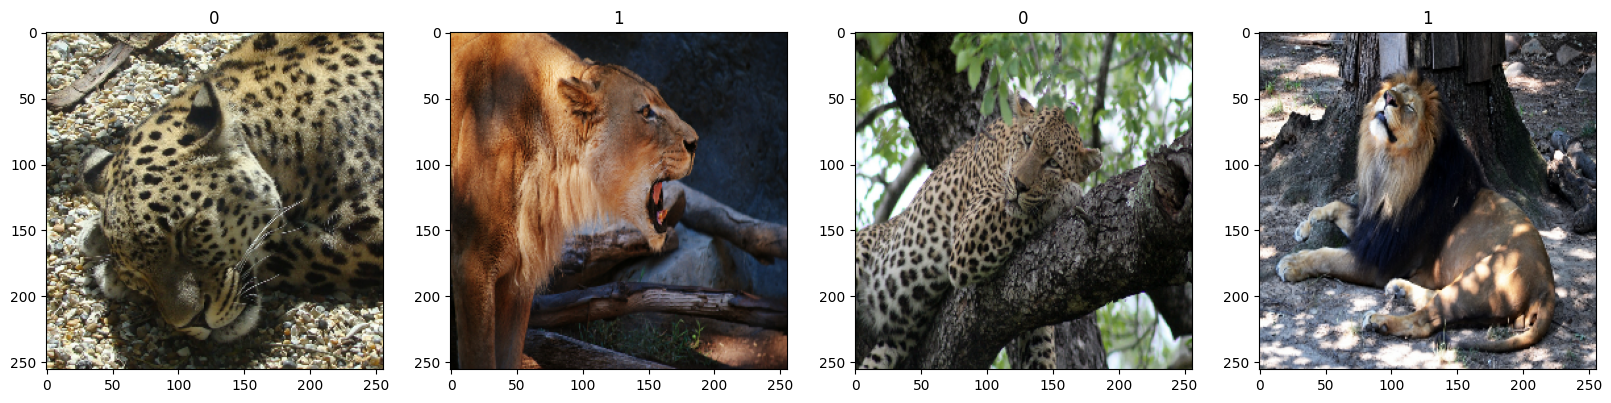

In [135]:
fig, ax = plt.subplots(ncols=4, figsize=(20,20))
for idx, img in enumerate(batch[0][:4]):
    ax[idx].imshow(img.astype(int))
    ax[idx].title.set_text(batch[1][idx])

# Preprocessing

In [136]:
# transform the batch array
# since the values inside the array represent rgb values, the max value is 255
data = data.map(lambda x, y: (x/255, y))

scaled_iterator = data.as_numpy_iterator()
batch = scaled_iterator.next()

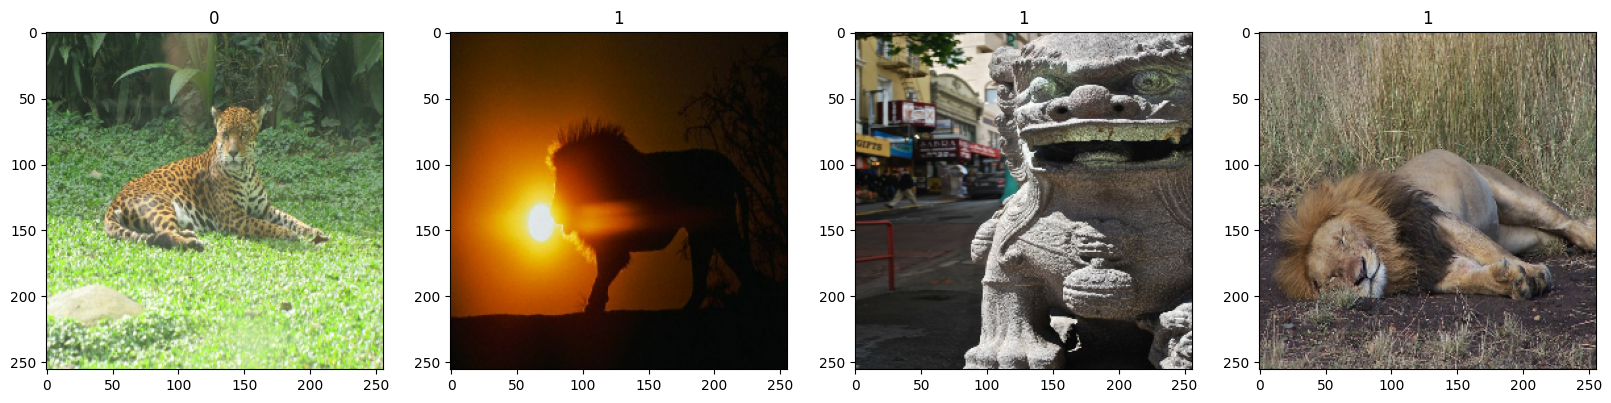

In [137]:
fig, ax = plt.subplots(ncols=4, figsize=(20,20))
for idx, img in enumerate(batch[0][:4]):
    ax[idx].imshow(img)
    ax[idx].title.set_text(batch[1][idx])

In [138]:
# max value of batch must be 1

def check_max_value(batch):
    max_val = batch[0].max()
    if max_val != 1:
        print("Error: Maximum value is not equal to 1. Actual value:", max_val)
    else:
        print("The max value of the batch is equal to 1, so please continue")

# execute the function
check_max_value(batch)

The max value of the batch is equal to 1, so please continue


In [139]:
len(data)

7

In [140]:
train_size = int(len(data)*0.7) # train data size
val_size = int(len(data)*0.2)+1 # validation of the model
test_size = int(len(data)*0.1)+1 # used for final evaluation state

In [141]:
# Data separation
# For training, validation, and eventually testing
train = data.take(train_size)
val = data.skip(train_size).take(val_size)
test = data.skip(train_size+val_size).take(test_size)

# Model

In [142]:
# important further tensorflow libraries
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPool2D, Dense, Flatten, Dropout

In [143]:
model = Sequential()

In [144]:
model.add(Conv2D(16, (3,3), 1, activation= "relu", input_shape=(256,256,3))) # 16 Filters, 3x3 window, stride=1
model.add(MaxPool2D()) # compresses information, only takes high values in account

model.add(Conv2D(32, (3,3), 1, activation= "relu" ))
model.add(MaxPool2D()) 

model.add(Conv2D(16, (3,3), 1, activation= "relu" ))
model.add(MaxPool2D()) 

model.add(Flatten())

model.add(Dense(256, activation='relu'))
model.add(Dense(1, activation='sigmoid')) # transforms input to value between 0 and 1

In [145]:
model.compile('adam', loss=tf.losses.BinaryCrossentropy(), metrics=['accuracy'])

In [146]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_3 (Conv2D)           (None, 254, 254, 16)      448       
                                                                 
 max_pooling2d_3 (MaxPoolin  (None, 127, 127, 16)      0         
 g2D)                                                            
                                                                 
 conv2d_4 (Conv2D)           (None, 125, 125, 32)      4640      
                                                                 
 max_pooling2d_4 (MaxPoolin  (None, 62, 62, 32)        0         
 g2D)                                                            
                                                                 
 conv2d_5 (Conv2D)           (None, 60, 60, 16)        4624      
                                                                 
 max_pooling2d_5 (MaxPoolin  (None, 30, 30, 16)       

In [147]:
# Creates the logging function. Callbacks are logged to observe model performance during time
logdir = 'logs'
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=logdir)

In [148]:
# Train the model
hist = model.fit(train, epochs=20, validation_data=val, callbacks=[tensorboard_callback])

Epoch 1/20


4/4 [==============================] - 2s 422ms/step - loss: 0.8182 - accuracy: 0.4453 - val_loss: 0.6826 - val_accuracy: 0.5469
Epoch 2/20
4/4 [==============================] - 2s 397ms/step - loss: 0.6977 - accuracy: 0.5078 - val_loss: 0.6790 - val_accuracy: 0.6250
Epoch 3/20
4/4 [==============================] - 2s 396ms/step - loss: 0.6715 - accuracy: 0.6094 - val_loss: 0.6430 - val_accuracy: 0.7969
Epoch 4/20
4/4 [==============================] - 2s 400ms/step - loss: 0.6678 - accuracy: 0.7188 - val_loss: 0.6025 - val_accuracy: 0.8438
Epoch 5/20
4/4 [==============================] - 2s 397ms/step - loss: 0.6241 - accuracy: 0.6328 - val_loss: 0.6519 - val_accuracy: 0.6250
Epoch 6/20
4/4 [==============================] - 2s 400ms/step - loss: 0.5874 - accuracy: 0.6484 - val_loss: 0.5711 - val_accuracy: 0.6094
Epoch 7/20
4/4 [==============================] - 2s 399ms/step - loss: 0.5540 - accuracy: 0.7344 - val_loss: 0.5265 - val_accuracy: 0.7812
Epoch 8/20
4/4 [===============

In [149]:
# show history performance
hist.history

{'loss': [0.8181763291358948,
  0.697688102722168,
  0.671505331993103,
  0.6677573323249817,
  0.6241008043289185,
  0.5874435901641846,
  0.5540063977241516,
  0.463323712348938,
  0.36138296127319336,
  0.38927531242370605,
  0.29214033484458923,
  0.29461178183555603,
  0.2512170970439911,
  0.1636202335357666,
  0.1798933744430542,
  0.15500584244728088,
  0.15242770314216614,
  0.09606228023767471,
  0.11954569071531296,
  0.0845266655087471],
 'accuracy': [0.4453125,
  0.5078125,
  0.609375,
  0.71875,
  0.6328125,
  0.6484375,
  0.734375,
  0.859375,
  0.9296875,
  0.765625,
  0.8984375,
  0.90625,
  0.9140625,
  0.9609375,
  0.921875,
  0.9609375,
  0.9765625,
  0.984375,
  0.953125,
  0.984375],
 'val_loss': [0.6825981140136719,
  0.6790435314178467,
  0.6430304646492004,
  0.6024981737136841,
  0.6519489288330078,
  0.5711188316345215,
  0.5265029668807983,
  0.37024885416030884,
  0.37476950883865356,
  0.390216588973999,
  0.29527121782302856,
  0.2655103802680969,
  0.177

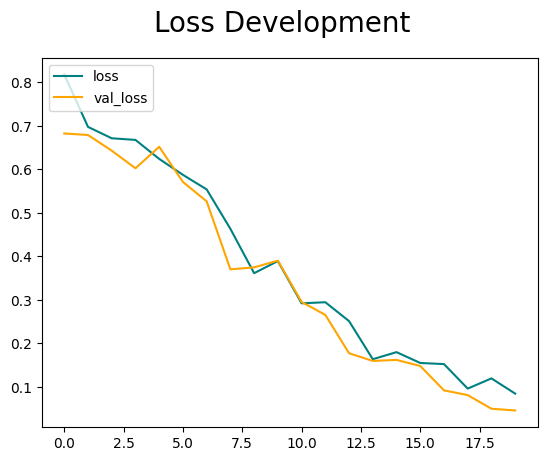

In [150]:
# plot performance

fig = plt.figure()
plt.plot(hist.history['loss'], color='teal', label='loss')
plt.plot(hist.history['val_loss'], color='orange', label='val_loss')
fig.suptitle('Loss Development', fontsize=20)
plt.legend(loc='upper left')
plt.show()


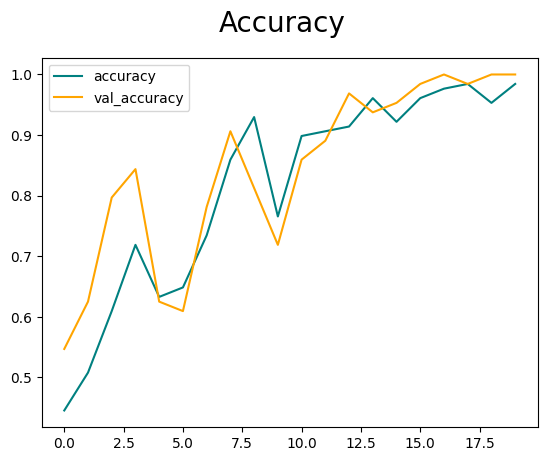

In [151]:
fig = plt.figure()

plt.plot(hist.history['accuracy'], color='teal', label='accuracy')
plt.plot(hist.history['val_accuracy'], color='orange', label='val_accuracy')
fig.suptitle('Accuracy', fontsize=20)
plt.legend(loc="upper left")
plt.show()

# Model Evaluation

In [152]:
from tensorflow.keras.metrics import Precision, Recall, BinaryAccuracy

In [153]:
prec = Precision()
recall = Recall()
accur = BinaryAccuracy()

In [154]:
len(test)

1

In [155]:
for batch in test.as_numpy_iterator():
    X, y = batch # X: set of images, y: true value
    yhat = model.predict(X) # creates predictions for image (X)
    prec.update_state(y, yhat) 
    recall.update_state(y, yhat)
    accur.update_state(y, yhat)

1/1 [==============================] - 0s 52ms/step


In [156]:
print(f'Precision:{prec.result().numpy()}, Recall:{recall.result().numpy()}, Accuracy:{accur.result().numpy()}')

Precision:1.0, Recall:1.0, Accuracy:1.0


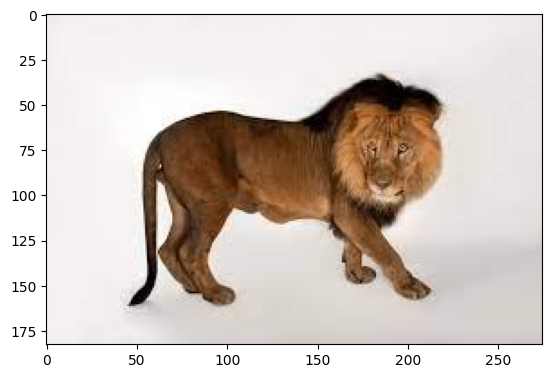

In [157]:
# trying the model on new data / images
img = cv2.imread('Test_Images/Lion2.jpg')
plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
plt.show()

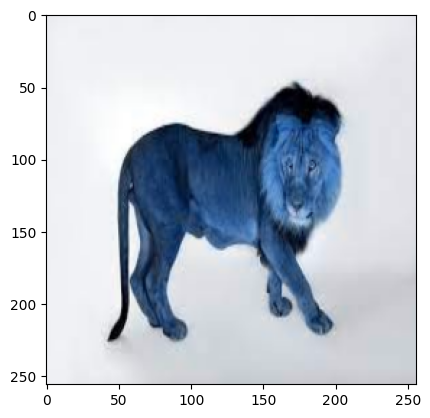

In [158]:
resize = tf.image.resize(img, (256,256))
plt.imshow(resize.numpy().astype(int))
plt.show()

In [159]:
np.expand_dims(resize, 0).shape

(1, 256, 256, 3)

In [160]:
yhat = model.predict(np.expand_dims(resize/255, 0))
yhat

1/1 [==============================] - 0s 20ms/step


array([[0.0051272]], dtype=float32)

# Save the Model

In [161]:
from tensorflow.keras.models import load_model

In [162]:
model.save(os.path.join('models', 'lioncheetahmodel.h5'))

/Users/denco_23/anaconda3/lib/python3.11/site-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [163]:
new_model = load_model(os.path.join('models', 'lioncheetahmodel.h5'))

In [164]:
new_model